In [1]:
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.vector_ar.vecm import coint_johansen

from pmdarima.model_selection import train_test_split as time_train_test_split
from sklearn import metrics
from sklearn.model_selection import ParameterGrid 

from statsmodels.tsa.api import VAR
from statsmodels.tsa.statespace.varmax import VARMAX
from pmdarima import auto_arima
from scipy import stats

import warnings
warnings.filterwarnings("ignore")

In [2]:
import pandas as pd
import numpy as np

In [3]:
from statsmodels.tsa.stattools import kpss

In [4]:
import matplotlib.pyplot as plt
%matplotlib inline

In [5]:
df = pd.read_csv('dataset/doge.csv')

In [6]:
df.head()

,Date,Open,High,Low,Close
0,2019-01-01,0.002319,0.002382,0.002246,0.002365
1,2019-01-02,0.002378,0.002407,0.002315,0.002354
2,2019-01-03,0.002358,0.002441,0.002268,0.002294
3,2019-01-04,0.002297,0.002331,0.002174,0.002270
4,2019-01-05,0.002292,0.002316,0.002212,0.002258


In [7]:
df.index = df['Date']

In [8]:
df.head()

,Date,Open,High,Low,Close
Date,,,,,
2019-01-01,2019-01-01,0.002319,0.002382,0.002246,0.002365
2019-01-02,2019-01-02,0.002378,0.002407,0.002315,0.002354
2019-01-03,2019-01-03,0.002358,0.002441,0.002268,0.002294
2019-01-04,2019-01-04,0.002297,0.002331,0.002174,0.002270
2019-01-05,2019-01-05,0.002292,0.002316,0.002212,0.002258


In [9]:
df.drop(columns=['Date','Open','High','Low'],inplace=True)

In [10]:
df.head()

,Close
Date,
2019-01-01,0.002365
2019-01-02,0.002354
2019-01-03,0.002294
2019-01-04,0.002270
2019-01-05,0.002258


In [11]:
df.index = pd.to_datetime(df.index)

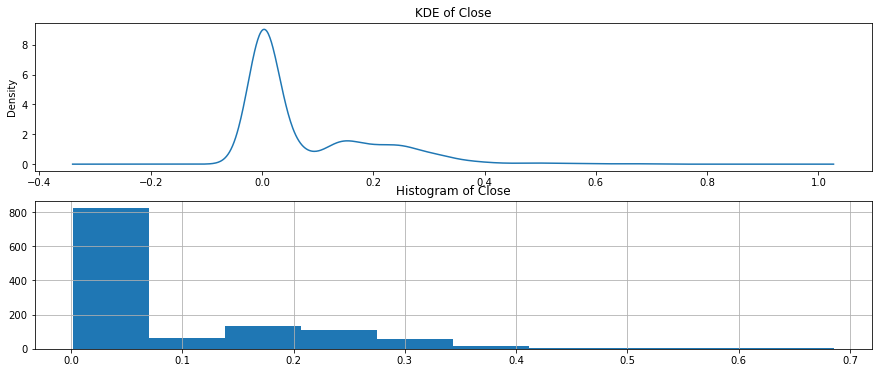

In [12]:
for feature in df[["Close"]]:
    plt.figure(1,figsize=(15,6))
    plt.subplot(212)
    plt.title(f"Histogram of {str(feature)}")
    df[str(feature)].hist()
    plt.subplot(211)
    plt.title(f"KDE of {str(feature)}")
    df[str(feature)].plot(kind="kde")
    plt.show()

In [13]:
def mean_absolute_percentage_error(y_true,y_pred):
    y_true,y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true-y_pred)/y_true))*100


In [14]:
def time_series_evaluation_metric(y_true,y_pred):
    '''
    We calculate the following evaluation metrics:
    
    -MSE
    -MAE
    -RMSE
    -MAPE
    -R^2
    
    Args:
    y_true: the real value 
    y_pred: the 
    
    '''
    
    print(f'MSE is: {metrics.mean_squared_error(y_true,y_pred)}')
    print(f'MAE is: {metrics.mean_absolute_error(y_true,y_pred)}')
    print(f'RMSE is:{np.sqrt(metrics.mean_squared_error(y_true,y_pred))}')
    print(f'MAPE is:{metrics.mean_absolute_percentage_error(y_true,y_pred)}')
    print(f'R2 is:{metrics.r2_score}')

In [15]:
def Augmented_Dickey_Fuller_test(series, column_name):
    '''
    Args:
    series():value of column
    column_name:Name of the column
    
    return:
    p-value    
    
    '''
    print(f"Result of dickey fuller test for:{column_name}")
    dftest= adfuller(series,autolag='AIC')
    dfoutput = pd.Series(dftest[0:4],['Test Statistic','P-value','No lag Used','Number of obervation'])
    
    for key,value in dftest[4].items():
        dfoutput['Critical value (%s)'%key] = value
    print(dfoutput)
    
    
    print("Conclusion:===>")
    if dftest[0] <= dftest[4]['5%']:

        print("Reject the null hypothesis")
    else:
        print(dftest[1])
        print("Failed to reject the null hypothesis")
    
    
    

In [16]:
def cointegration_test(df):
    '''test if there is long relationship between features'
    (args) value of columns to be checked'
    
    returns:
     '''
    res = coint_johansen(df,-1,5)
    d = {'0.90':0,'0.95':1,'0.99':2}
    traces = res.lr1
    cvts = res.cvt[:,d[str(1-0.05)]]
    
    def adjust(val,length=6):
        return str(val).ljust(length)
    
    print('column name>Test stat >C(95%)=> signif\n','--'*20)
    for col,trace,cvt in zip(df.columns ,traces ,cvts ):
        print(adjust(col),'>',adjust(round(trace,2),9),">",adjust(cvt,8),'=>',trace>cvt)
        

In [17]:
def inverse_diff(actual_df,df_pred):
    
    #fungsi ini digunakan untuk mengubah nilai y_prediction yg di train dengan dataset yang telah terdifferensiasi.
    #dengan menambahkan setiap nilai y_prediction dengan nilai akhir dari dataset actual yg tidak di differensiasi.
    #intinya adalah mengubah nilai y_prediction yg terdifferensiasi menjadi tidak terdifferensiasi.
    df_res = df_pred.copy()
    columns = actual_df.columns
    
    for col in columns:
        result = actual_df[col].iloc[-1] + df_res.cumsum()
        
    return result

# check for stationary using ADF

In [18]:
for name,column in df[['Close']].iteritems():
    Augmented_Dickey_Fuller_test(df[name],name)
    print("\n")

Result of dickey fuller test for:Close
Test Statistic            -1.999680
P-value                    0.286714
No lag Used               23.000000
Number of obervation    1193.000000
Critical value (1%)       -3.435843
Critical value (5%)       -2.863966
Critical value (10%)      -2.568061
dtype: float64
Conclusion:===>
0.2867136399446516
Failed to reject the null hypothesis




# Check for stationary using KPSS

In [19]:
def kpss_test(series, **kw):
    statistic,p_value,n_lags,critical_values = kpss(series,regression="c")
    
    print(f'KPSS statistic:{statistic}')
    print(f'p-value:{p_value}')
    print(f'num of lag used:{n_lags}')
    print('Critical value')
    
    for key,value in critical_values.items():
        print(f'{key}:{value}')
    print(f'Result: The series is {"not " if p_value < 0.05 else ""}stationary')

In [20]:
for name,column in df[['Close']].iteritems():
    kpss_test(df[name])
    print('\n')

KPSS statistic:2.9292802091832564
p-value:0.01
num of lag used:23
Critical value
10%:0.347
5%:0.463
2.5%:0.574
1%:0.739
Result: The series is not stationary




# Train test split

we need to split the train and test first, because we dont want the test data to have the inverse-difference.

In [21]:
X = df[['Close']]
trainX,testX = time_train_test_split(X,test_size=60)

In [22]:
train_diff = trainX.diff()
train_diff.dropna(inplace=True)

In [23]:
train_diff

,Close
Date,
2019-01-02,-0.000010
2019-01-03,-0.000060
2019-01-04,-0.000025
2019-01-05,-0.000012
2019-01-06,0.000031
...,...
2022-02-26,-0.000140
2022-02-27,-0.004618
2022-02-28,0.010443


In [24]:
train_diff.iloc[-1]

Close   -0.001017
Name: 2022-03-02 00:00:00, dtype: float64

In [25]:
for name,column in train_diff.iteritems():
    Augmented_Dickey_Fuller_test(train_diff[name],name)
    print("\n")

Result of dickey fuller test for:Close
Test Statistic         -7.113611e+00
P-value                 3.881660e-10
No lag Used             2.300000e+01
Number of obervation    1.132000e+03
Critical value (1%)    -3.436140e+00
Critical value (5%)    -2.864097e+00
Critical value (10%)   -2.568131e+00
dtype: float64
Conclusion:===>
Reject the null hypothesis




In [26]:
for name,column in train_diff.iteritems():
    kpss_test(train_diff[name])
    print("\n")

KPSS statistic:0.04496332693523283
p-value:0.1
num of lag used:23
Critical value
10%:0.347
5%:0.463
2.5%:0.574
1%:0.739
Result: The series is stationary




# Cointergration Test

In [27]:
cointegration_test(train_diff)

column name>Test stat >C(95%)=> signif
 ----------------------------------------
Close  > 272.36    > 4.1296   => True


# SARIMA


P(AR)
q(MA)
tr(trend)

In [28]:
param_value = {'p':[1,2,3],'q':[1,2,3]}
param_grid = list(ParameterGrid(param_value))

In [29]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

In [30]:
df_SARIMAX = pd.DataFrame(columns=['p','q','aic'])


for a,b in enumerate(param_grid):
    p = b.get('p')
    q = b.get('q')
    d=1
    model =  SARIMAX(train_diff,order=(p,d,q)).fit()
    aic = model.aic
    
    df_SARIMAX = df_SARIMAX.append({'p':p,'q':q,'aic':aic},ignore_index=True)

In [31]:
df_SARIMAX

,p,q,aic
0,1.0,1.0,-6399.104055
1,1.0,2.0,-6398.908263
2,1.0,3.0,-6399.339049
3,2.0,1.0,-6402.060565
4,2.0,2.0,-6403.900923
5,2.0,3.0,-6386.061926
6,3.0,1.0,-6409.812983
7,3.0,2.0,-6389.704719
8,3.0,3.0,-6407.230415


In [32]:
best_sarimax = df_SARIMAX.sort_values(by=['aic'],ascending = True).head()

In [33]:
p_sarimax = best_sarimax['p'].iloc[0]
q_sarimax = best_sarimax['q'].iloc[0]


print("AR :",p_sarimax)
print("MA :",q_sarimax)

AR : 3.0
MA : 1.0


# Fit SARIMA

In [34]:
import pickle
import os

In [35]:
filename = 'saved_model/doge_sarima_model.sav'
if os.path.exists(filename):
    model = pickle.load(open(filename,'rb'))
    print('model being loaded')
    
else:
    
    model = SARIMAX(train_diff[['Close']],order=(p_sarimax,1,q_sarimax)).fit(disp=True)
    os.makedirs('saved_model',exist_ok=True)
    save_file = 'saved_model/doge_sarima_model.sav'
    pickle.dump(model, open(save_file, 'wb'))
    print('saving the model')

model being loaded


In [36]:
y_pred = model.forecast(steps=len(testX))

In [37]:
y_pred[0]

-0.00019834993212478687

In [38]:
result = inverse_diff(trainX,y_pred)

In [48]:
print(f'Evaluation metrics for Close')
time_series_evaluation_metric(testX[str('Close')] , result)
print('\n')

Evaluation metrics for Close
MSE is: 0.00017505774591777752
MAE is: 0.011403626917851312
RMSE is:0.013230938965839784
MAPE is:0.08595581506911501
R2 is:<function r2_score at 0x000001C8CD201310>




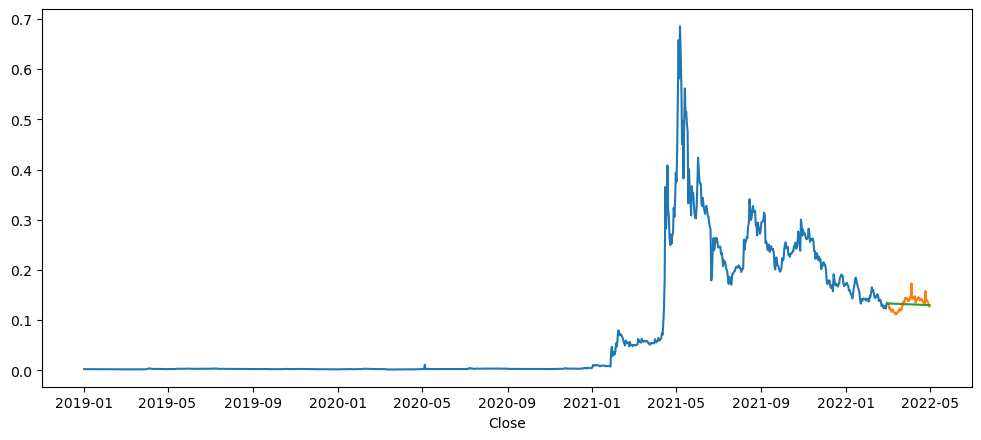

In [49]:
plt.figure(figsize=(12,5), dpi=100)
plt.plot(trainX[str('Close')])
plt.plot(testX[str('Close')])
plt.plot(result,label='predicting')
plt.xlabel(str('Close'))
plt.show()